# Big Data Management Project 4:
## Airline Delay and Cancellation Prediction with Spark ML


### Imports & Setup

### 1. Data Ingestion and Preparation

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BDM_Project4") \
    .getOrCreate()

In [2]:
df2009 = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv("input/2009.csv"))
df2009.printSchema()
df2009.show(5)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

#### Save as parquet, partitioned by extracted month

In [3]:
from pyspark.sql.functions import col, month, dayofweek

df2009 = df2009.withColumn("Month", month(col("FL_DATE")))
df2009 = df2009.withColumn("DayOfWeek", dayofweek(col("FL_DATE")))
df2009.write.mode("overwrite").partitionBy("Month").parquet("/home/jovyan/input/2009_parquet/")

### 2. Cleaning and Preprocessing

In [4]:
df2009 = df2009.drop("Unnamed: 27")

df2009 = df2009.withColumnRenamed("OP_CARRIER", "UniqueCarrier")
df2009 = df2009.withColumnRenamed("OP_CARRIER_FL_NUM", "UniqueCarrierFlightNumber")

df2009_cleaned = df2009.dropna(subset=['FL_DATE', 'UniqueCarrier'])

df2009_cleaned = df2009_cleaned.filter(col("DIVERTED") == 0.0)

df2009_cleaned = df2009_cleaned.withColumn("Month", month("FL_DATE")) \
                                 .withColumn("DayOfWeek", dayofweek("FL_DATE"))

### 3. Exploratory Analysis

In [5]:
df2009_cleaned.groupBy("CANCELLED").count().show()

+---------+-------+
|CANCELLED|  count|
+---------+-------+
|      0.0|6326977|
|      1.0|  87038|
+---------+-------+



In [6]:
cancelled = df2009_cleaned.filter(df2009_cleaned["CANCELLED"] == 1.0)
cancelled.count()

87038

In [7]:
# Top 10 carriers by number of flights
top_10_carriers = cancelled.groupBy("UniqueCarrier").count().orderBy("count", ascending=False).limit(10)
top_10_carriers.show()

+-------------+-----+
|UniqueCarrier|count|
+-------------+-----+
|           MQ|10695|
|           AA| 9191|
|           WN| 8405|
|           OO| 7423|
|           EV| 6314|
|           UA| 6213|
|           XE| 5193|
|           OH| 5108|
|           US| 5047|
|           DL| 4799|
+-------------+-----+



In [8]:
# Count cancellation reasons
cancel_reasons = cancelled.groupBy("CANCELLATION_CODE").count().orderBy("count", ascending=False)
cancel_reasons.show()

+-----------------+-----+
|CANCELLATION_CODE|count|
+-----------------+-----+
|                B|36651|
|                A|35568|
|                C|14799|
|                D|   20|
+-----------------+-----+



From Kaggle:
Reason for Cancellation of flight:
- A - Airline/Carrier;
- B - Weather;
- C - National Air System;
- D - Security

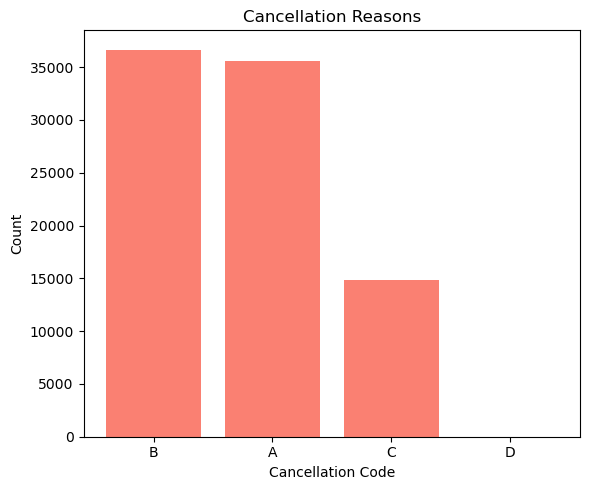

In [9]:
import matplotlib.pyplot as plt
cancel_reasons_pd = cancel_reasons.toPandas()

plt.figure(figsize=(6,5))
plt.bar(cancel_reasons_pd["CANCELLATION_CODE"], cancel_reasons_pd["count"], color='salmon')
plt.xlabel("Cancellation Code")
plt.ylabel("Count")
plt.title("Cancellation Reasons")
plt.tight_layout()
plt.show()

In [10]:
from pyspark.sql.functions import concat_ws

df2009_cleaned.withColumn("Route", concat_ws("->", "ORIGIN", "DEST")) \
               .groupBy("Route").count().orderBy("count", ascending=False).show(10)

+--------+-----+
|   Route|count|
+--------+-----+
|OGG->HNL|13328|
|HNL->OGG|12963|
|SFO->LAX|12132|
|LAX->SFO|12122|
|SAN->LAX|11020|
|LAX->SAN|11012|
|BOS->LGA|10870|
|LGA->BOS|10866|
|LAX->LAS|10682|
|LAS->LAX|10659|
+--------+-----+
only showing top 10 rows



In [11]:
class_dist = df2009_cleaned.groupBy("CANCELLED").count()
class_dist.show()

counts = class_dist.collect()
class_counts = {row['CANCELLED']: row['count'] for row in counts}

imbalance_ratio = max(class_counts.values()) / min(class_counts.values())
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

+---------+-------+
|CANCELLED|  count|
+---------+-------+
|      0.0|6326977|
|      1.0|  87038|
+---------+-------+

Imbalance Ratio: 72.69


### 4. Feature Engineering

Categorical features (UniqueCarrier, ORIGIN, DEST) were encoded using StringIndexer and OneHotEncoder. Numerical features (DEP_DELAY, ARR_DELAY, CRS_ELAPSED_TIME) were included directly. All features were combined into a single vector with VectorAssembler for use in modeling.

In [ ]:
# === 4. Feature Engineering === Eidi

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

cat_cols = ["UniqueCarrier", "ORIGIN", "DEST"]
# DEP_DELAY ja ARR_DELAY jätsin välja, kuna need veerud sisaldavad
#tühistatud lendude (CANCELLED = 1.0) puhul puuduvaid väärtusi.
# Kui need jätta sisse, siis VectorAssembler
# df_prepared_clean = df_prepared.dropna(subset=assembler_inputs + ["CANCELLED"])
#viskab need read välja (Eemalab kõik read, kus mõni
#VectorAssembler sisend või 'CANCELLED' on null."
# Mudel ei saa õppida tühistatud lendude pealt.
# Kasutasin ainult CRS_ELAPSED_TIME, mis on kõigi lendude puhul olemas.
# ehk siis tehtniliselt, siia peab vaatama veerunimesid mille puhul
# tunnused oleks kõigi lendue puhul ka olemas, mitte null valuga
num_cols = ["CRS_ELAPSED_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]


indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") for col in cat_cols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec", handleInvalid="keep") for col in cat_cols]

assembler_inputs = [col + "_Vec" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features", handleInvalid="skip")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

pipeline_model = pipeline.fit(df2009_cleaned)
df_prepared = pipeline_model.transform(df2009_cleaned)

df_prepared_clean = df_prepared.dropna(subset=assembler_inputs + ["CANCELLED"])

df_prepared_clean.select("features", "CANCELLED").show(5, truncate=False)

+--------------------------------------------------------------+---------+
|features                                                      |CANCELLED|
+--------------------------------------------------------------+---------+
|(617,[7,43,331,614,615,616],[1.0,1.0,1.0,62.0,1100.0,1202.0]) |0.0      |
|(617,[7,34,343,614,615,616],[1.0,1.0,1.0,82.0,1510.0,1632.0]) |0.0      |
|(617,[7,34,340,614,615,616],[1.0,1.0,1.0,70.0,1100.0,1210.0]) |0.0      |
|(617,[7,43,331,614,615,616],[1.0,1.0,1.0,77.0,1240.0,1357.0]) |0.0      |
|(617,[7,46,331,614,615,616],[1.0,1.0,1.0,105.0,1715.0,1900.0])|0.0      |
+--------------------------------------------------------------+---------+
only showing top 5 rows



In [13]:
df2009_cleaned.filter("CANCELLED = 1.0").select("CRS_ELAPSED_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME").summary("count").show()

+-------+----------------+------------+------------+
|summary|CRS_ELAPSED_TIME|CRS_DEP_TIME|CRS_ARR_TIME|
+-------+----------------+------------+------------+
|  count|           87038|       87038|       87038|
+-------+----------------+------------+------------+



In [14]:
df_prepared.filter("CANCELLED = 1.0").select(*assembler_inputs).summary("count").show()

+-------+----------------+------------+------------+
|summary|CRS_ELAPSED_TIME|CRS_DEP_TIME|CRS_ARR_TIME|
+-------+----------------+------------+------------+
|  count|           87038|       87038|       87038|
+-------+----------------+------------+------------+



In [15]:
df_prepared_clean.groupBy("CANCELLED").count().show()

+---------+-------+
|CANCELLED|  count|
+---------+-------+
|      0.0|6326977|
|      1.0|  87038|
+---------+-------+



In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

cat_cols = ["UniqueCarrier", "ORIGIN", "DEST"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index") for col in cat_cols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in cat_cols]

num_cols = ["DEP_DELAY", "ARR_DELAY", "CRS_ELAPSED_TIME"]

assembler_inputs = [col + "_Vec" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df2009_cleaned)
df_prepared = pipeline_model.transform(df2009_cleaned)

df_prepared.select("features", "CANCELLED").show(5, truncate=False)

+------------------------------------------------------------+---------+
|features                                                    |CANCELLED|
+------------------------------------------------------------+---------+
|(611,[7,41,327,608,609,610],[1.0,1.0,1.0,-2.0,4.0,62.0])    |0.0      |
|(611,[7,32,339,608,609,610],[1.0,1.0,1.0,-1.0,-8.0,82.0])   |0.0      |
|(611,[7,32,336,608,609,610],[1.0,1.0,1.0,-1.0,-9.0,70.0])   |0.0      |
|(611,[7,41,327,608,609,610],[1.0,1.0,1.0,9.0,-12.0,77.0])   |0.0      |
|(611,[7,44,327,608,609,610],[1.0,1.0,1.0,-10.0,-38.0,105.0])|0.0      |
+------------------------------------------------------------+---------+
only showing top 5 rows



In [17]:
df_prepared.describe()
df_prepared.show()

+----------+-------------+-------------------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----+---------+-------------------+------------+----------+-----------------+----------------+----------------+--------------------+
|   FL_DATE|UniqueCarrier|UniqueCarrierFlightNumber|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Month|DayOfWeek|UniqueCarrier_Index|ORIGIN_Index|DEST_Index|UniqueCarrier_Vec|      ORIGIN_Vec|        DEST_Vec|            features|
+----------+-------------+-------------------------+------+----+------

### 5. Modeling

In [18]:
#5 modeling eidi
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Split the data into train and test sets
train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)

#defining models
# Logistic Regression
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")

# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="CANCELLED", featuresCol="features")

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="CANCELLED", featuresCol="features")

# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol="CANCELLED", featuresCol="features")

In [19]:
# 3.evaluators eidi
evaluator_auc = BinaryClassificationEvaluator(labelCol="CANCELLED", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="CANCELLED", metricName="accuracy")

In [20]:
# 4. Define parameter grids eidi
lr_grid = ParamGridBuilder().addGrid(lr.maxIter, [10, 50]).build()
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10]).build()
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50]).build()
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 50]).build()

In [21]:
# 5. CrossValidators eidi
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=evaluator_auc, numFolds=3)
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=dt_grid, evaluator=evaluator_auc, numFolds=3)
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=evaluator_auc, numFolds=3)
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid, evaluator=evaluator_auc, numFolds=3)

In [23]:
# 6. Train models eidi
lr_model = cv_lr.fit(train_data)
dt_model = cv_dt.fit(train_data)
rf_model = cv_rf.fit(train_data)
gbt_model = cv_gbt.fit(train_data)

Py4JJavaError: An error occurred while calling o1238.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 65.0 failed 1 times, most recent failure: Lost task 4.0 in stage 65.0 (TID 322) (e79807e72922 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$5172/0x00007f5775330f80`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:288)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$5172/0x00007f5775330f80`: (struct<UniqueCarrier_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,ORIGIN_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEST_Vec:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DEP_DELAY:double,ARR_DELAY:double,CRS_ELAPSED_TIME:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:119)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$2.hasNext(InMemoryRelation.scala:288)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1597)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1524)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1588)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:379)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 26 more


In [ ]:
# 7. predictions eidi
lr_pred = lr_model.transform(test_data)
dt_pred = dt_model.transform(test_data)
rf_pred = rf_model.transform(test_data)
gbt_pred = gbt_model.transform(test_data)

In [ ]:
# 8. Evaluate eidi
results = []

def evaluate_model(name, predictions):
    accuracy = evaluator_acc.evaluate(predictions)
    auc = evaluator_auc.evaluate(predictions)
    results.append({"Model": name, "Accuracy": accuracy, "AUC": auc})
    print(f"{name} — Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

evaluate_model("Logistic Regression", lr_pred)
evaluate_model("Decision Tree", dt_pred)
evaluate_model("Random Forest", rf_pred)
evaluate_model("Gradient Boosted Trees", gbt_pred)

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

### 6. Explainability

In [ ]:
# AUC mõhjal on gbt_model.bestModel parem
best_tree_model = gbt_model.bestModel  # või rf_model.bestModel
importances = best_tree_model.featureImportances

In [ ]:
feature_names = assembler.getInputCols()

In [ ]:
feature_importance_list = list(zip(feature_names, importances))
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

In [ ]:
import matplotlib.pyplot as plt

top_k = 5
top_features = sorted_features[:top_k]

names = [f[0] for f in top_features]
scores = [f[1] for f in top_features]

plt.figure(figsize=(8, 5))
plt.barh(names[::-1], scores[::-1])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances (Tree-based Model)")
plt.tight_layout()
plt.show()

### 7. Model Persistence and Inference

In [ ]:
from pyspark.ml.pipeline import PipelineModel

# Load the saved model
loaded_model = PipelineModel.load("model/bestModel")

# Score the 2010 data
df2010 = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv("input/2010.csv"))
df2009.show(5)
predictions_2010 = loaded_model.transform(df2010)
predictions_2010.select("prediction", "probability").show(5)